<a href="https://www.kaggle.com/code/evelynartoria/potato-plant-disease-pytorch-vgg19?scriptVersionId=187124269" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import libraries

In [2]:
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import datasets

from torchvision.models import vgg19
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# Device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"default device set to {device}")

default device set to cuda


# Prepare the dataset

In [4]:
def make_dataset(folder_path):
    converter = ToTensor()
    return datasets.ImageFolder(root=folder_path, transform=converter, target_transform=None)
    
dataset = make_dataset("/kaggle/input/potato-plant-diseases-data/PlantVillage/PlantVillage")

print(dataset.class_to_idx)
print(dataset.classes)

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}
['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
train_split = int(len(dataset) * 0.8)
test_split = int(len(dataset) - train_split)

train_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_split, test_split], generator=torch.Generator(device=device))

print(len(train_dataset))
print(len(test_dataset))

1721
431


In [6]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, generator=torch.Generator(device=device))
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True, generator=torch.Generator(device=device))

# View data

In [7]:
def plot_image(image_tensor):
    plt.imshow(image_tensor.permute(1, 2, 0).cpu())
    
def plot_random_image(dataset):
    x = torch.randint(0, len(dataset), (1,)).item()
    image_tensor = dataset[x][0]
    image_label = dataset[x][1]
    plot_image(image_tensor)
    
    print(f"label is --> {image_label} ({dataset.dataset.classes[image_label]})")

1721 431
label is --> 0 (Potato___Early_blight)


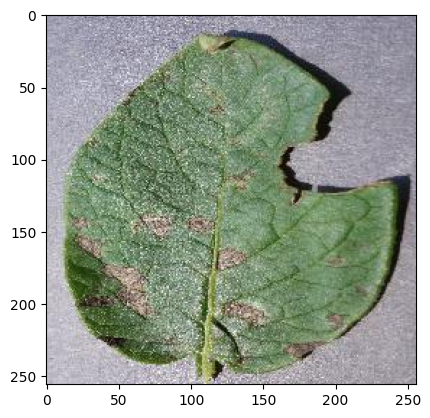

In [8]:
print(len(train_dataset), len(test_dataset))
plot_random_image(dataset=test_dataset)

# Define the model, optimizer and loss function

In [9]:
vgg = vgg19()

n_classes = len(train_dataset.dataset.classes)
vgg.classifier[-1] = nn.Linear(in_features=vgg.classifier[-1].in_features, out_features=n_classes)

print(vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)


In [10]:
optimizer = torch.optim.Adam(params=vgg.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

# Training loop

In [11]:
def train_model(model, dataloader, loss_fn, optimizer, epochs):
    model.train()
    
    for epoch in range(epochs):
        for batch, (images, labels) in tqdm(enumerate(dataloader)):
            logits = model(images.to(device))
            loss = loss_fn(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            if batch % 10 == 0:
                print(f"loss for batch {batch} --> {loss} at epoch {epoch}") 
                
    print(f"loss for the very last batch --> {loss}")

In [12]:
train_model(model=vgg, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, epochs=10)

1it [00:01,  1.36s/it]

loss for batch 0 --> 1.1033111810684204 at epoch 0


11it [00:06,  1.96it/s]

loss for batch 10 --> 0.9116330146789551 at epoch 0


21it [00:11,  1.99it/s]

loss for batch 20 --> 1.0135074853897095 at epoch 0


31it [00:16,  2.03it/s]

loss for batch 30 --> 0.9620559215545654 at epoch 0


41it [00:21,  2.00it/s]

loss for batch 40 --> 0.8233612179756165 at epoch 0


51it [00:26,  2.02it/s]

loss for batch 50 --> 0.8291498422622681 at epoch 0


54it [00:27,  1.93it/s]
1it [00:00,  2.42it/s]

loss for batch 0 --> 0.8375617861747742 at epoch 1


11it [00:04,  2.41it/s]

loss for batch 10 --> 0.9939652681350708 at epoch 1


21it [00:08,  2.41it/s]

loss for batch 20 --> 0.8082818984985352 at epoch 1


31it [00:12,  2.43it/s]

loss for batch 30 --> 0.9447797536849976 at epoch 1


41it [00:16,  2.44it/s]

loss for batch 40 --> 0.7716694474220276 at epoch 1


51it [00:20,  2.42it/s]

loss for batch 50 --> 0.72523033618927 at epoch 1


54it [00:22,  2.44it/s]
1it [00:00,  2.41it/s]

loss for batch 0 --> 0.7572341561317444 at epoch 2


11it [00:04,  2.41it/s]

loss for batch 10 --> 0.7214330434799194 at epoch 2


21it [00:08,  2.42it/s]

loss for batch 20 --> 0.6440256834030151 at epoch 2


31it [00:12,  2.44it/s]

loss for batch 30 --> 0.5372135639190674 at epoch 2


41it [00:16,  2.44it/s]

loss for batch 40 --> 0.32087722420692444 at epoch 2


51it [00:20,  2.43it/s]

loss for batch 50 --> 0.3676835298538208 at epoch 2


54it [00:22,  2.44it/s]
1it [00:00,  2.43it/s]

loss for batch 0 --> 0.393929660320282 at epoch 3


11it [00:04,  2.43it/s]

loss for batch 10 --> 0.6065752506256104 at epoch 3


21it [00:08,  2.42it/s]

loss for batch 20 --> 0.4081845283508301 at epoch 3


31it [00:12,  2.44it/s]

loss for batch 30 --> 0.29944854974746704 at epoch 3


41it [00:16,  2.45it/s]

loss for batch 40 --> 0.22331583499908447 at epoch 3


51it [00:20,  2.43it/s]

loss for batch 50 --> 0.20526528358459473 at epoch 3


54it [00:21,  2.46it/s]
1it [00:00,  2.42it/s]

loss for batch 0 --> 0.23947833478450775 at epoch 4


11it [00:04,  2.43it/s]

loss for batch 10 --> 0.14558197557926178 at epoch 4


21it [00:08,  2.45it/s]

loss for batch 20 --> 0.1329275220632553 at epoch 4


31it [00:12,  2.44it/s]

loss for batch 30 --> 0.5425365567207336 at epoch 4


41it [00:16,  2.42it/s]

loss for batch 40 --> 0.27134817838668823 at epoch 4


51it [00:20,  2.44it/s]

loss for batch 50 --> 0.21530842781066895 at epoch 4


54it [00:22,  2.45it/s]
1it [00:00,  2.39it/s]

loss for batch 0 --> 0.3569744825363159 at epoch 5


11it [00:04,  2.45it/s]

loss for batch 10 --> 0.21136465668678284 at epoch 5


21it [00:08,  2.43it/s]

loss for batch 20 --> 0.27818986773490906 at epoch 5


31it [00:12,  2.45it/s]

loss for batch 30 --> 0.168256476521492 at epoch 5


41it [00:16,  2.40it/s]

loss for batch 40 --> 0.3567340075969696 at epoch 5


51it [00:20,  2.42it/s]

loss for batch 50 --> 0.26235225796699524 at epoch 5


54it [00:22,  2.45it/s]
1it [00:00,  2.44it/s]

loss for batch 0 --> 0.7725404500961304 at epoch 6


11it [00:04,  2.42it/s]

loss for batch 10 --> 0.21146143972873688 at epoch 6


21it [00:08,  2.43it/s]

loss for batch 20 --> 0.09465286880731583 at epoch 6


31it [00:12,  2.45it/s]

loss for batch 30 --> 0.13809923827648163 at epoch 6


41it [00:16,  2.43it/s]

loss for batch 40 --> 0.3454359471797943 at epoch 6


51it [00:20,  2.45it/s]

loss for batch 50 --> 0.11993631720542908 at epoch 6


54it [00:22,  2.45it/s]
1it [00:00,  2.37it/s]

loss for batch 0 --> 0.14218248426914215 at epoch 7


11it [00:04,  2.45it/s]

loss for batch 10 --> 0.15846392512321472 at epoch 7


21it [00:08,  2.46it/s]

loss for batch 20 --> 0.17302700877189636 at epoch 7


31it [00:12,  2.45it/s]

loss for batch 30 --> 0.17421479523181915 at epoch 7


41it [00:16,  2.45it/s]

loss for batch 40 --> 0.08077075332403183 at epoch 7


51it [00:20,  2.46it/s]

loss for batch 50 --> 0.11358454823493958 at epoch 7


54it [00:21,  2.46it/s]
1it [00:00,  2.43it/s]

loss for batch 0 --> 0.1023918092250824 at epoch 8


11it [00:04,  2.45it/s]

loss for batch 10 --> 0.08270663768053055 at epoch 8


21it [00:08,  2.42it/s]

loss for batch 20 --> 0.10071005672216415 at epoch 8


31it [00:12,  2.44it/s]

loss for batch 30 --> 0.1052098348736763 at epoch 8


41it [00:16,  2.41it/s]

loss for batch 40 --> 0.15386852622032166 at epoch 8


51it [00:20,  2.43it/s]

loss for batch 50 --> 0.08444524556398392 at epoch 8


54it [00:22,  2.45it/s]
1it [00:00,  2.42it/s]

loss for batch 0 --> 0.1788213849067688 at epoch 9


11it [00:04,  2.45it/s]

loss for batch 10 --> 0.1848836988210678 at epoch 9


21it [00:08,  2.42it/s]

loss for batch 20 --> 0.0852055549621582 at epoch 9


31it [00:12,  2.43it/s]

loss for batch 30 --> 0.18426477909088135 at epoch 9


41it [00:16,  2.41it/s]

loss for batch 40 --> 0.08702994883060455 at epoch 9


51it [00:21,  2.18it/s]

loss for batch 50 --> 0.3746073842048645 at epoch 9


54it [00:22,  2.43it/s]

loss for the very last batch --> 0.2861720025539398


# Model inference

In [13]:
def pred_random_image(model, dataset):
    x = torch.randint(0, len(dataset), (1,)).item()
    image_tensor = dataset[x][0]
    image_label = dataset[x][1]
    plot_image(image_tensor.cpu())
    
    print(f"label is --> {image_label} ({dataset.dataset.classes[image_label]})")

    model.eval()
    with torch.inference_mode():
        image_tensor = image_tensor.to(device)
        logits = model(image_tensor.unsqueeze(dim=0))
        pred = torch.argmax(torch.softmax(logits, dim=1), dim=1)

        print(f"model predicted --> {dataset.dataset.classes[pred.item()]}")

label is --> 1 (Potato___Late_blight)
model predicted --> Potato___Late_blight


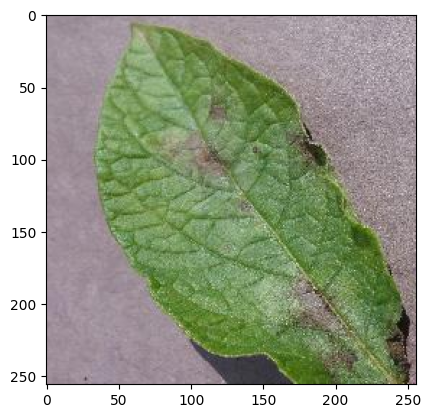

In [14]:
pred_random_image(model=vgg, dataset=test_dataset)